In [0]:
#@markdown Run this cell to mount Google Drive.

!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&acces

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
import math
os.chdir("/content/drive/MSRDailyActivity3D/Depth/eat")

### Extract raw depth data from .bin files

In [0]:
fnames = []
for a in range(13, 14):
    for s in range(1, 11):
        for e in range(1, 3):
            fnames.append('a' + "{:02d}".format(a) + '_s' + "{:02d}".format(s) +
                          '_e' + "{:02d}".format(e) + '_depth.bin')
print(fnames)

['a13_s01_e01_depth.bin', 'a13_s01_e02_depth.bin', 'a13_s02_e01_depth.bin', 'a13_s02_e02_depth.bin', 'a13_s03_e01_depth.bin', 'a13_s03_e02_depth.bin', 'a13_s04_e01_depth.bin', 'a13_s04_e02_depth.bin', 'a13_s05_e01_depth.bin', 'a13_s05_e02_depth.bin', 'a13_s06_e01_depth.bin', 'a13_s06_e02_depth.bin', 'a13_s07_e01_depth.bin', 'a13_s07_e02_depth.bin', 'a13_s08_e01_depth.bin', 'a13_s08_e02_depth.bin', 'a13_s09_e01_depth.bin', 'a13_s09_e02_depth.bin', 'a13_s10_e01_depth.bin', 'a13_s10_e02_depth.bin']


In [0]:
fnames = ['a02_s10_e02_depth.bin']

In [0]:
# Byte order: little/big endian.
bo = "little"

for fname in fnames:
    with open(fname, "rb") as f:
        nframes = int.from_bytes(f.read(4), bo)
        ncols = int.from_bytes(f.read(4), bo)
        nrows = int.from_bytes(f.read(4), bo)

        filename = fname[:-4] + ".txt"
        with open(filename, "w") as g:
            g.write(str(nframes) + ',' + str(nrows) + ',' + str(ncols) + '\n')
            
            for frameId in range(nframes):
                for i in range(nrows):
                    # Read and write depth data.
                    for j in range(ncols):
                        if j != 0:
                            g.write(',')
                        g.write(str(int.from_bytes(f.read(4), bo)))
                    g.write('\n')

                    # Simply skip Kinect skeleton data.
                    f.read(ncols)
    print("Converted", fname, "to", filename)

Converted a02_s10_e02_depth.bin to a02_s10_e02_depth.txt


In [0]:
import matplotlib.pyplot as plt

filename = 'a02_s10_e02_depth.txt'

d = []
with open(filename) as f:
    first_line = f.readline()
    parts = [int(num) for num in first_line.split(',')]
    nframes = parts[0]
    nrows = parts[1]
    ncols = parts[2]

    for k in range(nframes):
        depth_map = [f.readline() for i in range(nrows)]
        l = [[int(num) for num in line.split(',')] for line in depth_map]
        d.append(l)

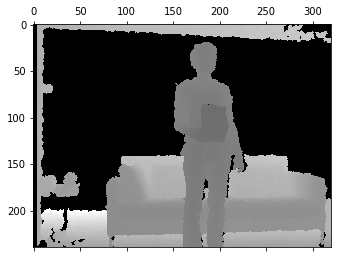

In [0]:
plt.matshow(d[0], cmap=plt.cm.gist_gray)
plt.show()

### Convert raw depth data to point cloud

In [0]:
cx = 343.645038678435410 # main point, the center of the image
cy = 229.805975111304460
fx = 458.455478616934780 # focal length in the direction of x and y
fy = 458.199272745572390

def depth_to_point_cloud_pos(x, y, d):
    pz = d
    px = (x - cx) * pz / fx
    py = (y - cy) * pz / fy
    return (px, py, pz)

In [0]:
def max_value(lst):
    return max([max(sublst) for sublst in lst])

def min_value(lst):
    return min([min(sublst) for sublst in lst])

def shift_over_zero(lst):
    min_val = min_value(lst)
    if min_val < 0:
        offset = -min_val
        return [[x + offset for x in sublst] for sublst in lst]
    return lst

NORM_CT = 255

def normalize(mat, max_val):
    nrows = len(mat)
    ncols = len(mat[0])
    nmat = [[0 for j in range(ncols)] for i in range(nrows)]

    for i in range(nrows):
        for j in range(ncols):
            nmat[i][j] = round(mat[i][j] * NORM_CT / max_val)
            
    return nmat


# Testing...
test_mat = [[-0.0, -0.0, -0.0, -2056.073893889615], [200, 1400, 1401, 600]]
print(max_value(test_mat))
print(shift_over_zero(test_mat))
print(normalize(test_mat, max_value(test_mat)))

1401
[[2056.073893889615, 2056.073893889615, 2056.073893889615, 0.0], [2256.073893889615, 3456.073893889615, 3457.073893889615, 2656.073893889615]]
[[0, 0, 0, -374], [36, 255, 255, 109]]


In [0]:
Xs = []
Ys = []
Zs = []
for k in range(nframes):
    frame_xs = []
    frame_ys = []
    frame_zs = []
    for i in range(nrows):
        for j in range(ncols):
            (xs, ys, zs) = depth_to_point_cloud_pos(i, j, d[k][i][j])
            frame_xs.append(xs)
            frame_ys.append(ys)
            frame_zs.append(zs)
    Xs.append(frame_xs)
    Ys.append(frame_ys)
    Zs.append(frame_zs)

In [0]:
Xs = shift_over_zero(Xs)
Ys = shift_over_zero(Ys)
Zs = shift_over_zero(Zs)

In [0]:
max_val = max([max_value(lst) for lst in [Xs, Ys, Zs]])
min_val = min([min_value(lst) for lst in [Xs, Ys, Zs]])

t = 0.55 * max_value(Zs)

for k in range(nframes):
    for i in range(len(Xs[0])):
        if Zs[k][i] > t:
            Xs[k][i] = min_val
            Ys[k][i] = min_val
            Zs[k][i] = min_val

In [0]:
# Normalize all values between 0 and NORM_CT.
max_val = max([max_value(lst) for lst in [Xs, Ys, Zs]])

Xs = normalize(Xs, max_val)
Ys = normalize(Ys, max_val)
Zs = normalize(Zs, max_val)

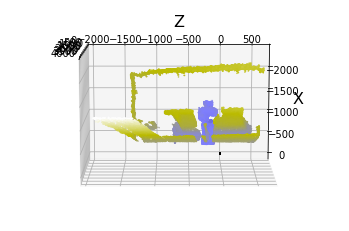

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

fig = plt.figure()

# ----- Plot point cloud -----
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xs[0], Ys[0], Zs[0], c=Zs[0],
           cmap=cm.gist_stern, s=0.3)

plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
plt.ylabel('Z', fontsize=16)

ax.view_init(100, 0)
plt.draw()
plt.show()

### Cartesian projections

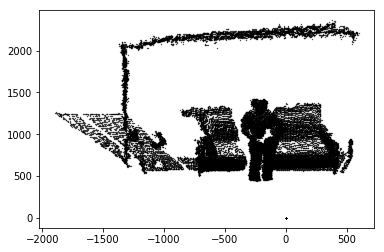

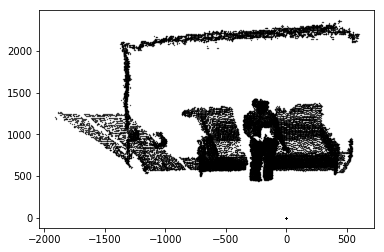

In [0]:
#@title XOY projection (front view) { run: "auto", display-mode: "form" }
frame_id = 28 #@param {type:"slider", min:0, max:215, step:1}

fig = plt.figure()
ax = fig.add_subplot(111, facecolor='white')

# ----- Plot projections -----
plt.scatter(Ys[frame_id], [-x for x in Xs[frame_id]], c='black', s=0.1)
plt.grid(False)
plt.show()


In [0]:
# Compute front view map.
map_f = []
for k in range(nframes):
    frame_map = [[0] * (NORM_CT + 1) for _ in range(NORM_CT + 1)]
    for x, y in zip(Xs[k], Ys[k]):
        frame_map[x][y] = 1
    map_f.append(frame_map)

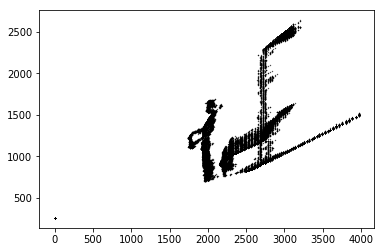

In [0]:
#@title XOZ projection (side view) { run: "auto", display-mode: "form" }
frame_id = 53 #@param {type:"slider", min:0, max:215, step:1}

fig = plt.figure()
ax = fig.add_subplot(111, facecolor='white')

# ----- Plot projections -----
plt.scatter(Zs[frame_id], [-x + NORM_CT for x in Xs[frame_id]], c='black', s=0.1)
plt.grid(False)
plt.show()

In [0]:
# Compute side view map.
map_s = []
for k in range(nframes):
    frame_map = [[0] * (NORM_CT + 1) for _ in range(NORM_CT + 1)]
    for x, z in zip(Xs[k], Zs[k]):
        frame_map[x][z] = 1
    map_s.append(frame_map)

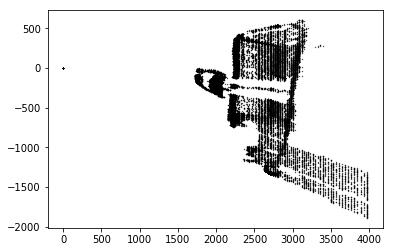

In [0]:
#@title YOZ projection (top view) { run: "auto", display-mode: "form" }
frame_id = 38 #@param {type:"slider", min:0, max:215, step:1}

fig = plt.figure()
ax = fig.add_subplot(111, facecolor='white')

# ----- Plot projections -----
ax = plt.scatter(Zs[frame_id], Ys[frame_id], c='black', s=0.1)
plt.grid(False)
plt.show()

In [0]:
# Compute top view map.
map_t = []
for k in range(nframes):
    frame_map = [[0] * (NORM_CT + 1) for _ in range(NORM_CT + 1)]
    for y, z in zip(Ys[k], Zs[k]):
        frame_map[y][z] = 1
    map_t.append(frame_map)

### Compute DMM

In [0]:
from math import sqrt

def get_dmm(map_f):
    dmm = [[0 for j in range(NORM_CT + 1)] for i in range(NORM_CT + 1)]
    
    for k in range(1, nframes):
        old_map = map_f[k - 1]
        cur_map = map_f[k]
        for i in range(NORM_CT + 1):
            for j in range(NORM_CT + 1): 
                #if abs(cur_map[i][j] - old_map[i][j]) > 0:
                if cur_map[i][j] != old_map[i][j]:
                    dmm[i][j] += 1
    return dmm

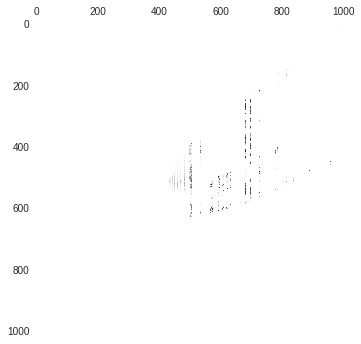

In [0]:
#@title DMM { run: "auto", display-mode: "form" }
dmm_type = 'Side' #@param ["Front", "Side", "Top"]

dmm = None
if dmm_type == 'Front':
    dmm = get_dmm(map_f)
elif dmm_type == 'Side':
    dmm = get_dmm(map_s)
elif dmm_type == 'Top':
    dmm = get_dmm(map_t)
    
ax = plt.matshow(dmm, cmap=plt.cm.binary)
plt.grid(b=None)
plt.show()